<a href="https://colab.research.google.com/github/zenaiev/hep/blob/main/invmass/invmass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://root.cern/download/root_v6.32.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz
!tar -xzf root_v6.32.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz
import os
pwd = os.getcwd()
os.environ['ROOTSYS'] = pwd + '/root'
os.environ['PATH'] += ':' + pwd + '/root/bin'
os.environ['LD_LIBRARY_PATH'] += ':' + pwd + '/root/lib'
import sys
sys.path.append(pwd + 'root/lib')
import ROOT
print(ROOT.__version__)

--2024-09-11 14:22:26--  https://root.cern/download/root_v6.32.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz
Resolving root.cern (root.cern)... 188.184.49.144, 2001:1458:d00:55::100:c
Connecting to root.cern (root.cern)|188.184.49.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300006880 (286M) [application/x-gzip]
Saving to: ‘root_v6.32.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz’

4-gcc11.4.tar.gz     89%[================>   ] 256.34M  25.3MB/s    eta 2s     

100%|██████████| 1000/1000 [00:09<00:00, 110.93it/s]


Number of signal events #1 = 994.0388645786218 +- 34.98440341852908
Number of signal events #2 = 1099.7185408040825 +- 36.30121215667105
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      227.909
NDf                       =          245
Edm                       =  2.88316e-06
NCalls                    =         1202
p0                        =      9.94039   +/-   0.349844    
p1                        =     0.497285   +/-   0.000460491  	 (limited)
p2                        =    0.0117313   +/-   0.000374577  	 (limited)
p3                        =      10.9972   +/-   0.363012    
p4                        =      1.86264   +/-   0.00235902   	 (limited)
p5                        =    0.0686642   +/-   0.00216162   	 (limited)
p6                        =     -100.859   +/-   0.613922    
p7                        =      549.669   +/-   0.549537    
p8                        =     -756.965   +/-   0.234469    
p9                    

Warning in <TROOT::Append>: Replacing existing TH1: hInvMass (Potential memory leak).
Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Info in <TCanvas::Print>: pdf file invmass.pdf has been created
Info in <TCanvas::Print>: png file invmass.png has been created


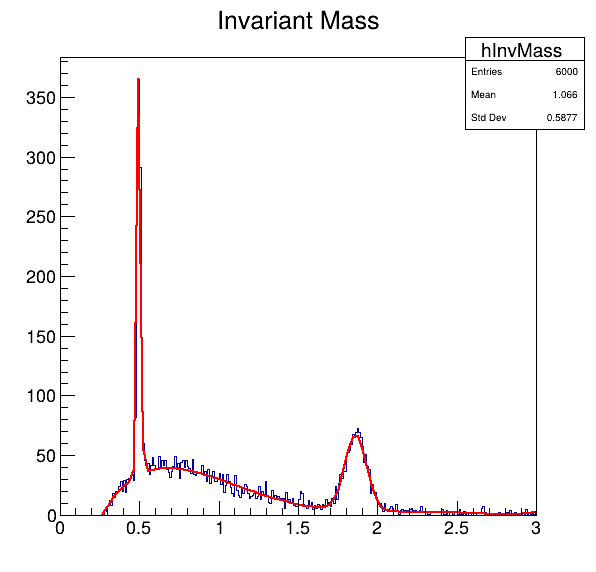

In [3]:
import ROOT
import math
import random
import tqdm
import sys


def generate_and_decay(parent_mass, daughter_mass_1, daughter_mass_2):
  # Generate random values for momentum and direction
  momentum = random.expovariate(1.0)  # Exponential distribution for momentum
  theta = random.uniform(0, math.pi)       # Uniform in [0, pi]
  phi = random.uniform(0, 2 * math.pi)     # Uniform in [0, 2pi]

  # Create a 3-momentum vector using spherical coordinates
  px = momentum * math.sin(theta) * math.cos(phi)
  py = momentum * math.sin(theta) * math.sin(phi)
  pz = momentum * math.cos(theta)

  # Create parent particle
  parent = ROOT.Math.PxPyPzMVector(px, py, pz, parent_mass)

  # Decay
  daughter1, daughter2 = two_body_decay(parent, daughter_mass_1, daughter_mass_2)

  if 0:
    print(f'parent: {parent}, m = {parent.M()}')
    print(f'daughter1: {daughter1}, m = {daughter1.M()}')
    print(f'daughter2: {daughter2}, m = {daughter2.M()}')
    #sys.exit(0)

  # Smear momentum of daughter tracks
  daughter1 = smear_momentum(daughter1)
  daughter2 = smear_momentum(daughter2)

  if 0:
    print(f'daughter1: {daughter1}, m = {daughter1.M()}')
    print(f'daughter2: {daughter2}, m = {daughter2.M()}')
    sys.exit(0)

  return [daughter1, daughter2]

# Function to smear particle momentum
def smear_momentum(particle):
  fluct = random.normalvariate(1., 0.05) # Normal distribution with mean = 1 and width = 0.05 (5% resolution)
  return ROOT.Math.PxPyPzMVector(particle.X() * fluct, particle.Y() * fluct, particle.Z() * fluct, particle.M())

# Function to generate a two-body decay in the rest frame of the parent particle
def two_body_decay(parent, m1, m2):
  # Calculate the momentum of the daughter particles in the parent's rest frame
  m0 = parent.M()  # Parent mass

  # Energy of the daughters in the rest frame
  # In the rest frame, the daughters have equal momenta (p12)
  p12 = math.sqrt((m0**2 - (m1 + m2)**2) * (m0**2 - (m1 - m2)**2)) / (2 * m0)
  E1 = (m0**2 + m1**2 - m2**2) / (2 * m0)
  E2 = (m0**2 + m2**2 - m1**2) / (2 * m0)

  # Momentum of the daughters in the rest frame
  p = math.sqrt(E1**2 - m1**2)
  #print(p, p12)

  # Generate random angles for isotropic decay
  theta = random.uniform(0, math.pi)
  phi = random.uniform(0, 2 * math.pi)

  # Momentum components for daughter 1 in the rest frame
  p1x = p * math.sin(theta) * math.cos(phi)
  p1y = p * math.sin(theta) * math.sin(phi)
  p1z = p * math.cos(theta)

  # Create four-momentum vectors for the two daughters in the rest frame
  daughter1 = ROOT.Math.PxPyPzMVector(p1x, p1y, p1z, m1)
  daughter2 = ROOT.Math.PxPyPzMVector(-p1x, -p1y, -p1z, m2)

  # Boost daughters back to the lab frame if the parent is moving
  boost_vector = ROOT.Math.Boost(parent.BoostToCM())
  daughter1 = ROOT.Math.PxPyPzMVector(boost_vector(daughter1))
  daughter2 = ROOT.Math.PxPyPzMVector(boost_vector(daughter2))

  return daughter1, daughter2



if __name__ == '__main__':
  if 1:
    # Set the number of particles to generate
    nParticles = 1000
    #nParticles = 10

    # Particle masses in GeV [https://pdg.lbl.gov/]
    mass_pi_ch = 0.13957
    mass_k_zero = 0.497611
    mass_d_zero = 1.86484

    # random seed for reproducible results
    random.seed(42)

    # Create a histogram to store generated momenta
    hInvMass = ROOT.TH1F("hInvMass", "Invariant Mass", 300, 0, 3)

    if 1:
      # Create tree (store events)
      fileout = ROOT.TFile("tracks.root", "recreate")
      tree = ROOT.TTree('tree', 'Tree with tracks')
      tracks_vec = ROOT.std.vector(ROOT.Math.PxPyPzMVector)()
      branch = tree.Branch('tracks', tracks_vec)

    # Loop over particles and generate random kinematics
    #for i in range(nParticles):
    for i in tqdm.tqdm(range(nParticles)):
      tracks = []
      tracks += generate_and_decay(mass_k_zero, mass_pi_ch, mass_pi_ch)
      tracks += generate_and_decay(mass_d_zero, mass_pi_ch, mass_pi_ch)
      assert len(tracks) == 4

      for itr1 in range(len(tracks)):
        for itr2 in range(itr1 + 1, len(tracks)):
          hInvMass.Fill((tracks[itr1] + tracks[itr2]).M())

      if 1:
        tracks_vec.clear()
        for tr in tracks:
          tracks_vec.push_back(tr)
        tree.Fill()

    # Write TTree to file
    if 1:
      fileout.cd()
      tree.Write()
      fileout.Close()

  # Read data from TTree
  if 0:
    filein = ROOT.TFile("tracks.root")
    tree = filein.Get('tree')
    tracks = ROOT.std.vector(ROOT.Math.PxPyPzMVector)()
    tree.SetBranchAddress('tracks', tracks)
    hInvMass = ROOT.TH1F("hInvMass", "Invariant Mass", 300, 0, 3)
    for ientr in range(tree.GetEntries()):
      tree.GetEntry(ientr)
      for itr1 in range(len(tracks)):
        for itr2 in range(itr1 + 1, len(tracks)):
          hInvMass.Fill((tracks[itr1] + tracks[itr2]).M())

  # Fit
  fitFunc = ROOT.TF1("fitFunc",
                     "[0]/(sqrt(2*TMath::Pi())*[2])*TMath::Exp(-0.5*((x-[1])/[2])^2)"   # First Gaussian
                     " + [3]/(sqrt(2*TMath::Pi())*[5])*TMath::Exp(-0.5*((x-[4])/[5])^2)" # Second Gaussian
                     " + [6] + [7]*x + [8]*x^2 + [9]*x^3 + [10]*x^4 + [11]*x^5",               # Polynomial (5th degree)
                     #"gaus(0) + gaus(3) + pol5(6)",               # Gaus + Gaus + Polynomial (5th degree)
                          -10, 10)
  fitFunc.SetParameters(1, 0.5, 0.01,  # Amplitude, mean, sigma of first Gaussian
                        1, 1.85, 0.05,  # Amplitude, mean, sigma of second Gaussian
                        0, 0, 0, 0, 0);    # Coefficients of the polynomial (0 by default anyway)
  #print(fitFunc.GetParameter(11))
  #fitFunc.SetParameter(11, 10.0)
  #print(fitFunc.GetParameter(11))
  fitFunc.SetParLimits(1, 0.48, 0.52) # K0 mass
  fitFunc.SetParLimits(2, 0., 0.1) # K0 width
  fitFunc.SetParLimits(4, 1.8, 1.9) # D0 mass
  fitFunc.SetParLimits(5, 0., 0.2) # D0 width
  hInvMass.Fit(fitFunc)
  bin_width = hInvMass.GetBinLowEdge(2) - hInvMass.GetBinLowEdge(1)
  print(f'Number of signal events #1 = {fitFunc.GetParameter(0)/bin_width} +- {fitFunc.GetParError(0)/bin_width}')
  print(f'Number of signal events #2 = {fitFunc.GetParameter(3)/bin_width} +- {fitFunc.GetParError(3)/bin_width}')

  # Create a canvas to draw the histogram
  canvas = ROOT.TCanvas("canvas", "Invariant Mass", 600, 600)
  hInvMass.Draw()

  # Save the histogram as an image
  canvas.SaveAs("invmass.pdf")
  canvas.SaveAs("invmass.png")
